# Intensity and speed export
This code will look through one file of intensity and speed data. Furthermore, it will fit a Smulders FR on the data using pytorch. 

The researched piece of highway here is the A13 from Rotterdam to Delft, on October 16th from 0:00 to 23:59. We chose this part, because it has a speed limit of 100kmph and no exits/entries. Furthermore, there are a lot of matrix signs above the highway, from which we can deduce when lanes are shut off and when the max-speed is (partially) lowered.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

In [18]:
# Define paths
datafolder = os.path.join(os.path.dirname(os.getcwd()), "data", "short_highway")
datafolder_intensityspeed = os.path.join(datafolder, "intensiteit-snelheid-export")
file1_path = os.path.join(datafolder_intensityspeed, "intensiteit-snelheid-export.csv")

In [19]:
# intensityspeed_filelist[0] is a png file, the rest are csv's with intensity-speed data
file1 = pd.read_csv(file1_path, low_memory=False)
file1["gem_dichtheid"] = file1["gem_intensiteit"] / file1["gem_snelheid"]

In the following piece of code, we will filter the relevant rows from the data. We do this by filtering the following subjects:
1. Filter out everything but 1 measuring location.
2. Only use the "anyVehicle" vehicle class.
3. We will remove all rows where there is no car measured (as seen by a speed of -1).
4. We remove technical exclusions.
5. We will remove everything before 7:00 and after 19:00. In the final project, we will also remove weekenddays from the data.
6. We aggregate the lanes for each interval (minute) by adding the intensities, and using a weighted average of the speeds.


In [22]:
# 1
file1_1_location = file1[file1.id_meetlocatie == "RWS01_MONIBAS_0131hrl0117ra"]
# 2
filtered = file1_1_location[file1_1_location.voertuigcategorie == "anyVehicle"]
# 3
filtered = filtered[filtered.gem_snelheid != -1]
# 4
filtered = filtered[filtered.technical_exclusion != "v"]    
# 5
filtered["start"] = pd.to_datetime(filtered.start_meetperiode)
mask = (filtered.start.dt.time >= pd.to_datetime("7:00").time()) & (filtered.start.dt.time < pd.to_datetime("19:00").time())
mask2 = (filtered.start.dt.weekday != 5) & (filtered.start.dt.weekday != 6)
filtered = filtered[mask & mask2]
# 6 (using much faster code, thanks to chatgpt)
filtered2 = filtered[["start", "id_meetlocatie"]].drop_duplicates()
grouped = filtered.groupby(["start", "id_meetlocatie"])
tot = grouped["gem_intensiteit"].transform("sum")
gem_snelheid_weighted = (filtered["gem_snelheid"] / tot * filtered["gem_intensiteit"]).groupby([filtered["start"], filtered["id_meetlocatie"]]).transform("sum")
filtered2["gem_intensiteit"] = tot
filtered2["gem_snelheid"] = gem_snelheid_weighted
filtered2["gem_dichtheid"] = filtered2["gem_intensiteit"] / filtered2["gem_snelheid"]
# filtered2 = pd.DataFrame({"start": filtered.start.unique()})
# for i, row in filtered2.iterrows():
#     subset = filtered.loc[filtered["start"] == row["start"]]
#     tot = subset["gem_intensiteit"].sum()
#     filtered2.at[i, "gem_intensiteit"] = tot
#     filtered2.at[i, "gem_snelheid"] = (subset["gem_snelheid"] / tot * subset["gem_intensiteit"]).sum()
# filtered2["gem_dichtheid"] = filtered2["gem_intensiteit"] / filtered2["gem_snelheid"]
filtered = filtered2
filtered

,start,id_meetlocatie,gem_intensiteit,gem_snelheid,gem_dichtheid
2100,2023-10-16 07:00:00,RWS01_MONIBAS_0131hrl0117ra,3720.0,99.032258,37.563518
2105,2023-10-16 07:01:00,RWS01_MONIBAS_0131hrl0117ra,3600.0,101.483333,35.473805
2110,2023-10-16 07:02:00,RWS01_MONIBAS_0131hrl0117ra,3300.0,102.054545,32.335649
2115,2023-10-16 07:03:00,RWS01_MONIBAS_0131hrl0117ra,4080.0,100.720588,40.508103
2120,2023-10-16 07:04:00,RWS01_MONIBAS_0131hrl0117ra,3780.0,97.936508,38.596434
...,...,...,...,...,...
5675,2023-10-16 18:55:00,RWS01_MONIBAS_0131hrl0117ra,2820.0,104.510638,26.982899
5680,2023-10-16 18:56:00,RWS01_MONIBAS_0131hrl0117ra,2220.0,106.378378,20.868902
5685,2023-10-16 18:57:00,RWS01_MONIBAS_0131hrl0117ra,2220.0,104.162162,21.312922
5690,2023-10-16 18:58:00,RWS01_MONIBAS_0131hrl0117ra,3660.0,102.524590,35.698753


# Plotting
We have now filtered the correct data from the csv file. First, we will use some plots to visualise the data.

In [6]:
# Create lin regression model
X2 = filtered["gem_dichtheid"].values.reshape(-1, 1)
Y2= filtered["gem_snelheid"].values.reshape(-1, 1)
lin_regressor2 = LinearRegression()
lin_regressor2.fit(X2, Y2)
Y2_pred = lin_regressor2.predict(X2)

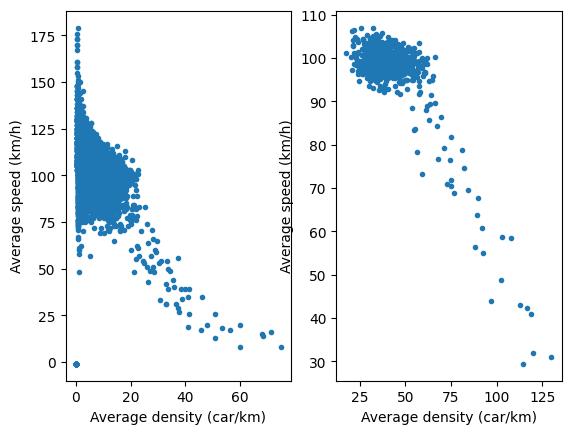

In [7]:
a = 1
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(file1_1_location["gem_dichtheid"], file1_1_location["gem_snelheid"], '.', alpha=a)
ax2.plot(filtered["gem_dichtheid"], filtered["gem_snelheid"], '.', alpha=a)
# ax2.plot(X2, Y2_pred)
for ax in [ax1, ax2]:
    ax.set_xlabel("Average density (car/km)")
    ax.set_ylabel("Average speed (km/h)")
plt.show()

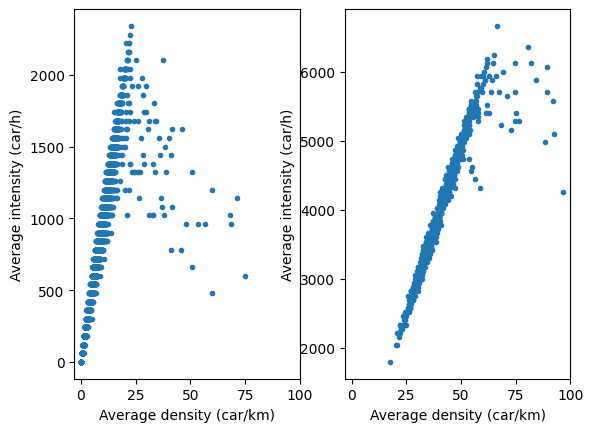

In [12]:
a = 1
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(file1_1_location["gem_dichtheid"], file1_1_location["gem_intensiteit"], '.', alpha=a)
ax2.plot(filtered["gem_dichtheid"], filtered["gem_intensiteit"], '.', alpha=a)
for ax in [ax1, ax2]:
    ax.set_xlim(-3, 100)
    # ax.set_ylim(-3, 150)
    ax.set_xlabel("Average density (car/km)")
    ax.set_ylabel("Average intensity (car/h)")
plt.show()

# Fitting

In [9]:
from godunovfunctions import *

In [15]:
q = filtered["gem_dichtheid"]
f = filtered["gem_intensiteit"]
u = filtered["gem_snelheid"]
fr = Smulders(
    u0=max(u),
    qj=max(q),
    qc=0.2*max(q)
)

history = fr.fit(q, f, epochs=3000, lr=0.0001)

Afterwards, plot the results of the fitting:

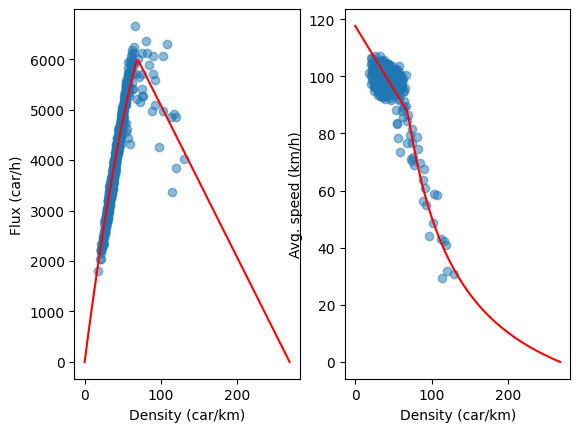

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

q_test = np.linspace(0, fr.qj, 100)
f_test = fr.f(q_test)
u_test = fr.u(q_test)

ax1.scatter(q, f, alpha=0.5)
ax1.plot(q_test, f_test, "r")
ax1.set_xlabel('Density (car/km)')
ax1.set_ylabel("Flux (car/h)")
ax2.scatter(q, u, alpha=0.5)
ax2.plot(q_test, u_test, "r")
ax2.set_xlabel("Density (car/km)")
ax2.set_ylabel("Avg. speed (km/h)")
plt.show()